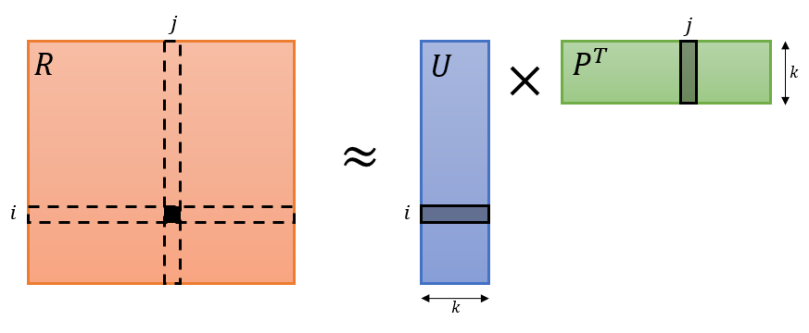

- co-clustering 문제를 해결하기 위한 가장 인기 있는 알고리즘 중 하나는 (특히 collaborative recommender system) 매트릭스 인자화(Matrix Factorization(MF) 이라고 한다. 가장 단순한 형태로, m users, n items에 의해 rating된 행렬 R ∈ Rm*n 를 가정해보자. R에 MF 테크닉을 적용해 보면 U∈Rm*k, P∈Rn*k (따라서 R ≈ U*P) 두 개의 매트릭스로 구분할 수 있다.

In [1]:
import pandas as pd
import os

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:

ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
ratings.rename(columns={'rating':'count'}, inplace=True)
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

In [4]:
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = ratings.join(movies.set_index('movie_id'), on='movie_id')
ratings.head()

,user_id,movie_id,count,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [6]:
ratings = ratings.drop(columns=['timestamp', 'genre'])
ratings.head()

,user_id,movie_id,count,title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,James and the Giant Peach (1996)
2,1,914,3,My Fair Lady (1964)
3,1,3408,4,Erin Brockovich (2000)
4,1,2355,5,"Bug's Life, A (1998)"


In [7]:
print('# of movie_id: ', ratings['movie_id'].nunique())
print('# of title   : ', ratings['title'].nunique())
print('# of user_id : ', ratings['user_id'].nunique())

# of movie_id:  3628
# of title   :  3628
# of user_id :  6039


In [8]:
movie_count = ratings.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [9]:
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [12]:

movies[movies['title'].str.lower().str.contains('lion king', regex=False)]

,movie_id,title,genre
360,364,"Lion King, The (1994)",Animation|Children's|Musical


In [14]:

my_favorite_id = [1240, 2571, 1580 , 648, 3623]

my_favorite_title = []
for i in my_favorite_id:
    my_favorite_title.extend(list(movies[movies['movie_id'] == i]['title']))

my_movielist = pd.DataFrame({'user_id': ['Sung_Hoon']*5, 'movie_id': my_favorite_id, 'count': [5]*5, 'title': my_favorite_title})
my_movielist

,user_id,movie_id,count,title
0,Sung_Hoon,1240,5,"Terminator, The (1984)"
1,Sung_Hoon,2571,5,"Matrix, The (1999)"
2,Sung_Hoon,1580,5,Men in Black (1997)
3,Sung_Hoon,648,5,Mission: Impossible (1996)
4,Sung_Hoon,3623,5,Mission: Impossible 2 (2000)


In [15]:
if not ratings.isin({'user_id':['Sung_Hoon']})['user_id'].any():
    ratings = ratings.append(my_movielist, ignore_index=True)

ratings.tail(10)

,user_id,movie_id,count,title
836473,6040,1090,3,Platoon (1986)
836474,6040,1094,5,"Crying Game, The (1992)"
836475,6040,562,5,Welcome to the Dollhouse (1995)
836476,6040,1096,4,Sophie's Choice (1982)
836477,6040,1097,4,E.T. the Extra-Terrestrial (1982)
836478,Sung_Hoon,1240,5,"Terminator, The (1984)"
836479,Sung_Hoon,2571,5,"Matrix, The (1999)"
836480,Sung_Hoon,1580,5,Men in Black (1997)
836481,Sung_Hoon,648,5,Mission: Impossible (1996)
836482,Sung_Hoon,3623,5,Mission: Impossible 2 (2000)


### 기존의 ratings dataframe에 새로운 데이터(나의 시청기록) 를 추가 (my_movielist)


# --------------------------------------
# CSR matrix 생성 

### 참고로 여러분들이 사용하고 계실 컴퓨터의 메모리는 많아야 16GB일 테니 97GB나 되는 거대한 행렬을 메모리에 올려놓고 작업한다는 것은 불가능할 것입니다. 이런 경우의 좋은 대안이 되는 것이 CSR(Compressed Sparse Row) Matrix입니다. 다음 스텝에서 수행할 모델 학습의 input으로 사용할 데이터 타입을 CSR Matrix로 할 것입니다.

### CSR Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조입니다.

# ---------------------------------------

- data는 0이 아닌 원소를 차례로 기입한 값입니다.

- indices는 data의 각 요소가 어느 열(column)에 있는지를 표현한 index입니다

- indptr은 각 행(row)에서 0이 아닌 첫 번째 원소가 data 리스트에서 의 몇 번째에 해당하는지와 마지막에 data 벡터의 길이를 추가한 값입니다.

- 이를 통해 data의 요소들이 어느 행(row)에 있는지를 알 수 있는데요. 

- 다만 예시의 세 번째 행처럼 0이 아닌 원소가 없는 경우엔 그 다음 행의 값과 같은 값을 넣었습니다.

- CSR Matrix는 data, indices, indptr 로 행렬을 압축하여 표현합니다. 

- user id, 영화 제목을 고유한 개수만큼 indexing 

In [16]:

user_unique = ratings['user_id'].unique()
movie_unique = ratings['title'].unique()

user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [17]:
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()#user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱
if len(temp_user_data) == len(ratings):
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data
else:
    print('user_id column indexing Fail!!')

temp_movie_data = ratings['title'].map(movie_to_idx.get).dropna()#movie_to_idx.get을 통해 title컬럼의 모든 값을 인덱싱
if len(temp_movie_data) == len(ratings):
    print('title column indexing OK!!')
    ratings['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

ratings

user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,count,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4
...,...,...,...,...
836478,6039,1240,5,200
836479,6039,2571,5,124
836480,6039,1580,5,175
836481,6039,648,5,58


In [18]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['title'].nunique()

# csr_matrix
# shape 에서 M 이 num_user(유저 수 , 행을 의미) 
# N 이 num_movie (영화의 개수, 열을 의미) 입니다.
# 행렬 분해를 하면 이 Rating Matrix 가 P,Q 벡터의 행렬곱으로 표현 가능합니다

csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.title)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

# 모델 설계 및 훈련

- 우리는 Y를 고정시키고 X를 optimize한 다음, X를 고정시키고 Y를 optimize할 것이고 이를 수렴할 때 까지 반복한다. 이 방법이 ALS (Alternating Least Squares) 이다.

- non-convex 한 문제를 해결하기 위해, variable Y 고정 --> X 의 convex function 으로 반복적으로 최적화 한다.

- Gradient descent는 approximate한 방법으로 사용될 수 있지만 속도도 느리고 iteration cost가 많이 든다

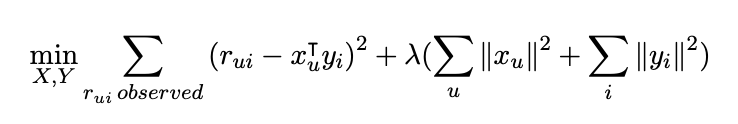

- 이 objective function이 ( xTu yi term 때문에) non-convex라는 점에 주목하자. 이것은 ‘NP-hard’ optimization 문제와 같다. 

In [19]:
#implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지입니다.
#이 패키지에 구현된 als(AlternatingLeastSquares) 모델을 사용하겠습니다.
# Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에,
# 한쪽을 고정시키고 
# 다른 쪽을 학습하는 방식을 번갈아 수행하는 
# AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있습니다.

from implicit.als import AlternatingLeastSquares
import os
import numpy as np

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

#### AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지
- 1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.

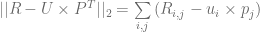

In [26]:
from tensorflow.python.keras import regularizers

als_model = AlternatingLeastSquares(factors=200, regularization=0.02, use_gpu=False, iterations=50, dtype=np.float32)


###  우리는 두 가지 유형의 변수(U와 P)를 배우는 것을 목표로 하고 있으며, 이 둘은 U x PT(p의 transpose) 로 묶여있다

### 실제 cost function 은

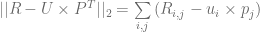

### 에 regularization term 을 더한 것이라는 것을 기억하자.


### U’ 와 V’ 가 미지의 변수라는 것은 이 cost function을 non-convex로 만든다.
### 만약 P를 고정시키고 U에 대해서만 최적화를 시킨다면, 이 문제는 선형 회귀의 문제로 전락할 뿐이다. 
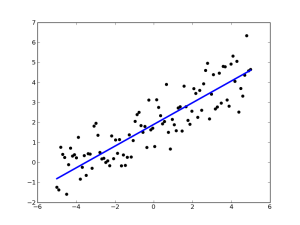


- 선형회귀에서 우리는 주어진 X와 y에 대해 제곱오차

- 를 최소화 시켜서 β를 구할 수 있다. 이 solution은 궁극적으로 OLS formula

에 의해 주어진다.

#  우리는 두 가지 유형의 변수(U와 P)를 배우는 것을 목표로 하고 있으며, 이 둘은 U x PT(p의 transpose) 로 묶여있다


# U’ 와 V’ 가 미지의 변수라는 것은 이 cost function을 non-convex로 만든다.
# 만약 P를 고정시키고 U에 대해서만 최적화를 시킨다면, 이 문제는 선형 회귀의 문제로 전락할 뿐이다. 

csr_data_transpose = csr_data.T
csr_data_transpose

In [28]:
als_model.fit(csr_data_transpose)

  0%|          | 0/50 [00:00<?, ?it/s]

# 훈련된 모델이 예측한 나의 선호도

In [29]:
Sung_Hoon, matrix = user_to_idx['Sung_Hoon'], movie_to_idx['Matrix, The (1999)']
Sung_Hoon_vector, matrix_vector = als_model.user_factors[Sung_Hoon], als_model.item_factors[matrix]

In [30]:
Sung_Hoon_vector

array([-0.07135654, -0.13234155, -0.15812355,  0.11375225, -0.48853514,
        0.12950078,  0.3803197 ,  0.6698204 ,  0.06332571,  0.38318157,
        0.14798804,  0.00961896, -0.17382619, -0.46468192, -0.12717725,
       -0.44550008, -0.10559744, -0.1522737 , -0.11113857,  0.16607507,
       -0.00098411,  0.02435666, -0.43929327,  0.12131877,  0.19447608,
       -0.14941272,  0.03991862, -0.18405423,  0.07957279, -0.3741901 ,
        0.18252988,  0.27063286, -0.25845388,  0.04948755,  0.02327451,
        0.16423956, -0.20560975,  0.21379407,  0.12267543,  0.29001102,
       -0.09331795,  0.08004329,  0.3828167 ,  0.03143059,  0.11680218,
       -0.2310435 ,  0.1989451 , -0.11834753,  0.16143167,  0.1710159 ,
        0.22806552, -0.2144638 , -0.44067165,  0.27415618,  0.14820771,
        0.22893418, -0.09180279, -0.19799861,  0.03202163, -0.09062856,
       -0.1307575 , -0.00361143,  0.47303772,  0.17434579,  0.4568453 ,
       -0.12656213, -0.19168657, -0.08678631, -0.11009546, -0.48

In [31]:
matrix_vector

array([-0.01456931, -0.00628199, -0.00557728, -0.00507404, -0.0375656 ,
       -0.00738357,  0.03706858,  0.05263565,  0.01303546,  0.02539265,
        0.02847099,  0.01842066, -0.03497742,  0.02436819, -0.03163422,
       -0.03261849, -0.015728  , -0.00546531,  0.01466178,  0.00040704,
        0.01378934, -0.00726698, -0.01090731, -0.00086338, -0.0091775 ,
       -0.01862698,  0.02927632,  0.00923629, -0.00835848, -0.04524051,
        0.03603068,  0.06656622, -0.00850186,  0.00117741, -0.01947336,
       -0.04094088,  0.02334822, -0.03239599,  0.03666784,  0.01454243,
       -0.04805114,  0.00550369,  0.03614247, -0.01682352,  0.02447874,
       -0.02087769,  0.04634386, -0.04039466,  0.02529987, -0.00275429,
        0.03705074, -0.00711515, -0.00431086,  0.0415729 , -0.00267027,
        0.02474703,  0.02473677, -0.01691935,  0.00029144,  0.0455073 ,
        0.03568802, -0.00982861,  0.03708714,  0.0190562 ,  0.04182921,
        0.01003443, -0.02126092,  0.00602497, -0.01698661, -0.03

In [32]:
np.dot(Sung_Hoon_vector, matrix_vector)

0.74113256

In [34]:
Platoon = movie_to_idx['Platoon (1986)']
Platoon_vector = als_model.item_factors[Platoon]
np.dot(Sung_Hoon_vector, Platoon_vector)

-0.09163608

- 선호 리스트에 없는 영화의 벡터를 계산
- 나의 벡터와 선호 리스트에 없는 영화 벡터를 내적한 결과
- 굉장히 낮은 값이 출력

# 내가 좋아하는 영화와 비슷한 영화 추천

In [35]:
favorite_movie = 'Mission: Impossible (1996)'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie 

[(58, 0.9999998),
 (138, 0.3306789),
 (82, 0.28541),
 (842, 0.2665728),
 (119, 0.2480751),
 (587, 0.24697652),
 (766, 0.24461387),
 (140, 0.243762),
 (2694, 0.23095866),
 (179, 0.22787717),
 (2777, 0.22637074),
 (118, 0.22407305),
 (714, 0.22179696),
 (156, 0.22169368),
 (769, 0.21078093)]

In [36]:
#(무비의 id, 유사도) Tuple 로 반환하고 있습니다. 무비의 id를 다시 무비의 이름으로 매핑 시켜 주겠습니다.
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['Mission: Impossible (1996)',
 'True Lies (1994)',
 'Lost World: Jurassic Park, The (1997)',
 'Basic Instinct (1992)',
 'Twister (1996)',
 'Batman Returns (1992)',
 'GoldenEye (1995)',
 'Clear and Present Danger (1994)',
 'Diamonds (1999)',
 'Rock, The (1996)',
 'Two Moon Juction (1988)',
 'Con Air (1997)',
 'Waterworld (1995)',
 'Mask of Zorro, The (1998)',
 'Black Beauty (1994)']

In [37]:
# 몇 번 더 반복해서 확인하기 위해 위의 코드를 함수로 만들고 확인해 보겠습니다.

def get_similar_movie(movie_title: str):
    movie_id = movie_to_idx[movie_title]
    #AlternatingLeastSquares 클래스에 구현되어 있는 similar_items 메서드를 통하여 비슷한 영화 아이디를 찾습니다.
    similar_movie = als_model.similar_items(movie_id, N=15)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie


In [38]:
get_similar_movie('Men in Black (1997)')

['Men in Black (1997)',
 'Jurassic Park (1993)',
 'Total Recall (1990)',
 'Terminator 2: Judgment Day (1991)',
 'Face/Off (1997)',
 'Independence Day (ID4) (1996)',
 'Matrix, The (1999)',
 'Fifth Element, The (1997)',
 'True Lies (1994)',
 'Lost World: Jurassic Park, The (1997)',
 'Schlafes Bruder (Brother of Sleep) (1995)',
 'Galaxy Quest (1999)',
 'Grumpy Old Men (1993)',
 'Get Shorty (1995)',
 'World of Apu, The (Apur Sansar) (1959)']

In [39]:
get_similar_movie('Terminator, The (1984)')

['Terminator, The (1984)',
 'Aliens (1986)',
 'Terminator 2: Judgment Day (1991)',
 'Die Hard (1988)',
 'Predator (1987)',
 'Alien (1979)',
 'Matrix, The (1999)',
 'Blade Runner (1982)',
 'Robocop (1987)',
 'Total Recall (1990)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Mad Max 2 (a.k.a. The Road Warrior) (1981)',
 'Indiana Jones and the Last Crusade (1989)',
 'Simon Sez (1999)',
 'Blue Collar (1978)']

# 내가 좋아할 만한 영화 추천

In [40]:
user = user_to_idx['Sung_Hoon']

movie_recommended = als_model.recommend(user, csr_data, N=15, filter_already_liked_items=True)
movie_recommended

[(92, 0.7642199),
 (62, 0.40825725),
 (107, 0.36032856),
 (651, 0.290118),
 (67, 0.28214636),
 (375, 0.27909935),
 (865, 0.23464571),
 (372, 0.2309219),
 (141, 0.2303139),
 (145, 0.21335195),
 (193, 0.21074753),
 (82, 0.18978979),
 (5, 0.18665108),
 (346, 0.18132521),
 (27, 0.16446409)]

In [41]:
[idx_to_movie[i[0]] for i in movie_recommended]

['Terminator 2: Judgment Day (1991)',
 'Total Recall (1990)',
 'Jurassic Park (1993)',
 'Aliens (1986)',
 'Gladiator (2000)',
 'Face/Off (1997)',
 'Predator (1987)',
 'X-Men (2000)',
 'Fugitive, The (1993)',
 'Fifth Element, The (1997)',
 'Alien (1979)',
 'Lost World: Jurassic Park, The (1997)',
 'Princess Bride, The (1987)',
 'Patriot, The (2000)',
 'Titanic (1997)']

### 앞서 구한 index 값을 이용하여, 내가 선호할만한 영화 제목을 출력

In [42]:
recommended = movie_to_idx['Jurassic Park (1993)']
explain = als_model.explain(user, csr_data, itemid=recommended)

[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Men in Black (1997)', 0.3058184700747352),
 ('Mission: Impossible (1996)', 0.05216433517574759),
 ('Matrix, The (1999)', 0.04579551848347929),
 ('Terminator, The (1984)', -0.02247966653059856),
 ('Mission: Impossible 2 (2000)', -0.023077168152236)]

In [44]:
recoms = [1,1,1,1,1,1,0,1,0,1,0,1,1,0,1,1,0,1,1,1]  # N = 20
NUM_ACTUAL_ADDED_ACCT = 15 
precs = []
recalls = []

for indx, rec in enumerate(recoms):
    precs.append(sum(recoms[:indx+1])/(indx+1))
    recalls.append(sum(recoms[:indx+1])/NUM_ACTUAL_ADDED_ACCT)

pd.DataFrame({'precision':precs, 'recall':recalls})

,precision,recall
0,1.000000,0.066667
1,1.000000,0.133333
2,1.000000,0.200000
3,1.000000,0.266667
4,1.000000,0.333333
5,1.000000,0.400000
6,0.857143,0.400000
7,0.875000,0.466667
8,0.777778,0.466667
9,0.800000,0.533333


Text(0.5, 1.0, 'P(i) vs. r(i) for Increasing $i$ for AP@20')

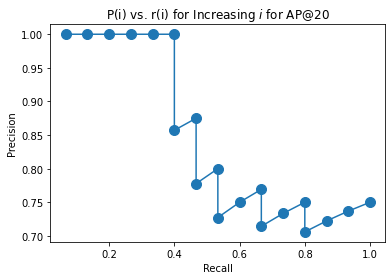

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(recalls, precs, markersize=10, marker="o")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("P(i) vs. r(i) for Increasing $i$ for AP@20")

### 추천된 6번째 영화까지는 모두 사용자의 액션을 이끌어 냈기 때문에 Precision이 1.0이지만
- 그 후부터 사용자가 관심갖지 않는 영화가 존재하기 때문에 점점 수치가 낮아지는 것을 볼 수 있다. 
- recall은 사용자가 관심있어하는 아이템 중에 우리가 추천한 아이템의 비율이기 때문에 k가 증가할 수록 함께 수치가 증가하는 것을 확인할 수 있다.

### 사용자의 선호 영화 리스트에 있는 영화들이 영화 추천에 어느정도 기여했는지 기여도를 확인
### 'Jurassic Park (1993)'에 대한 기여도를 확인한 결과, 'Men in Black (1997)'이 0.3179 정도로 꽤 높은 기여를 함

# 회고 

- data의 경우, 평점과 제목이 2개의 파일로 나눠져 있었다. 평점과 영화 제목의 경우, 많이 사용하는 데이터이기 때문에, join을 이용하여 두 개의 dataframe을 하나로 합쳐서 사용하였다.

- 결과를 보면, 선호 영화 리스트에 있는 'Matrix, The (1999)'의 벡터 내적 값은 약 0.63으로, 나름 높은 값을 얻었고, 'Platoon (1986)'이라는 영화와의 벡터 내적 값은 약 -0.07정도로 굉장히 낮은 값을 얻었다. 대체적으로 액션, 블록버스터 영화를 선호하는 입장에서 'Platoon (1986)'이라는 영화를 선호하지 않는 나의 선호도가 나름 잘 반영되었다고 생각된다.

- 내가 좋아하는 영화와 비슷한 추천 영화들에 대해서 살펴보면, 대체적으로 액션, 블록버스터와 같은 비슷한 장르의 영화들이 추천되었다. 또한, 내가 재밌게 본 영화나 좋아할만한 영화들이 추천된 것을 보면, 해당 장르에 대해서는 어느정도 추천 시스템 결과에 신뢰할 수 있다고 생각된다.

#### 유튜브, 넷플릭스, 인터넷 광고 등 여러 플랫폼에서 사용하는 추천 시스템에 대해서 궁금한 부분이 많았다. 인터넷 광고는 사용자의 검색어를 기반으로 추천한다고 느꼈지만, 유튜브나 넷플릭스는 어떤 식으로 영상을 추천하는 것인지 이해하기 힘들었다. 이번 노드를 통해서 추천 시스템에 대한 어느정도의 궁금증을 해결한 것 같다. 그러나, 노드를 진행하면서 생긴 의문은, '과연 이 모델을 혹은 이 결과를 신뢰할 수 있는가?' 이다. 선호하는 것이 명확한 사용자도 있지만, 매칭이 잘 되지 않는 선호도를 가진 사용자도 있을 것이다. (가령, 애니메이션 영화를 좋아하면서 블록버스터 영화를 좋아하는 사용자) 혹은, 흔히 말하는 매니아처럼 하나의 장르만을 선호하는 사람이 아닌, 모든 장르를 선호하는 사람도 존재할 것이다. 그런 사람들에게 추천 시스템이 잘 적용될까? 영화의 내용을 전부 확인하고 추천하는 것이 아니기에 추천 시스템에는 한계가 존재하는 것일까? 확실히 이번 노드는 신기했지만, 어려웠고, 여러 의문이 생기는 노드였다.